In [1]:
import os, time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import torch
import pickle
import matplotlib.pyplot as plt
import math
import json

In [2]:
import sys

sys.path.append("/home/lorena/Documents/Lorena_Thesis/Causal_CNN/")

from libs.network_analysis import evaluation

from libs.run_gene_thicket import run_gene_thicket
from libs.causal_cnn import LaRed
from libs.gene_thicket import preparedata
from libs.network_analysis import plot_graph, scores, plot_scores, plot_cartography, evaluation

In [3]:
gem = pd.read_csv('./inputs/Pancreas_Ms.csv', index_col = 0)

In [4]:
#import TF-target pairs
with open('./TF_targets_pancreas.json', 'r') as fp:
    TF_info = json.load(fp)

In [5]:
gem

,Sntg1,Snhg6,Ncoa2,Sbspon,Ube2w,Mcm3,Fam135a,Adgrb3,Tmem131,Tbc1d8,...,Sh3kbp1,Map3k15,Rai2,Rbbp7,Ap1s2,Tmem27,Uty,Ddx3y,Eif2s3y,Erdr1
latent_time,,,,,,,,,,,,,,,,,,,,,
0.000000,0.000000,0.857921,0.026586,0.401776,0.000000,0.612002,0.068434,0.0,0.126114,0.000000,...,0.073748,0.000000,0.000000,2.555160,0.017416,0.000000,0.0,0.000000,0.052809,0.309471
0.000098,0.000000,0.819684,0.074002,0.460997,0.000000,0.670135,0.043932,0.0,0.105880,0.000000,...,0.071369,0.000000,0.000000,2.511190,0.016854,0.000000,0.0,0.000000,0.051105,0.358489
0.001534,0.000000,0.743263,0.024169,0.368141,0.000000,0.689397,0.084544,0.0,0.099463,0.000000,...,0.067044,0.000000,0.000000,2.437821,0.015833,0.000000,0.0,0.000000,0.048008,0.360190
0.001806,0.000000,0.791554,0.087456,0.341530,0.000000,0.627678,0.072489,0.0,0.115690,0.000000,...,0.063212,0.000000,0.000000,2.637856,0.014928,0.000000,0.0,0.000000,0.017178,0.424407
0.001827,0.000000,0.732293,0.071690,0.415872,0.000000,0.559196,0.042559,0.0,0.122329,0.000000,...,0.088896,0.000000,0.000000,2.670796,0.016327,0.000000,0.0,0.000000,0.018789,0.270087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.988439,0.157203,0.161856,0.051701,0.000000,0.025401,0.133490,0.368879,0.0,0.211524,0.072604,...,0.101230,0.087159,0.092814,0.997826,0.372894,1.528696,0.0,0.414930,0.152787,0.563463
0.992532,0.096790,0.178178,0.080889,0.000000,0.026941,0.136510,0.341479,0.0,0.125920,0.029498,...,0.107365,0.092441,0.103701,0.873581,0.293988,1.432920,0.0,0.546952,0.282226,0.362964
0.996108,0.042070,0.180707,0.056548,0.000000,0.027783,0.068095,0.335227,0.0,0.121775,0.000000,...,0.110720,0.125769,0.086590,0.916712,0.306899,1.510251,0.0,0.545867,0.133292,0.378401


In [6]:
time = list(gem.index)

In [7]:
len(TF_info.keys())

1857

In [8]:
#general parameters
epochs = 1000
kernel_size = 4
layers = 0
lr = 0.01
optimizername = 'Adam'
seed = 1111
dilation_c = 4

## Past - Present

In [17]:
pred_df = pd.DataFrame()

for gene in list(TF_info.keys()):
    
    target_name = gene
    tfs_name = TF_info[target_name]
    
    try:
        #train_data
        X_train, _ = preparedata(target_name, tfs_name, gem)
        input_channels = X_train.size()[1]
        
        model = LaRed(input_channels, layers, kernel_size=kernel_size, cuda=False, dilation_c=dilation_c)
        model.load_state_dict(torch.load('./saved_models_pancreas/' + target_name + '.pt'))
        
        model.eval()
        
        pred_values = model(X_train)
        pred_values = pred_values.cpu()
        pred_values = pred_values.detach().numpy().flatten()
        
        pred_df[target_name] = pred_values
    
    except:
        pass

/home/lorena/anaconda3/envs/causal_cnn_env/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [18]:
pred_df

,0610010F05Rik,0610011F06Rik,0610030E20Rik,1110002L01Rik,1110034G24Rik,1500009L16Rik,1700011H14Rik,1700026L06Rik,1700086L19Rik,1810041L15Rik,...,Zfp804a,Zfp90,Zfp949,Zfpm1,Zfr2,Zim1,Zmym5,Znrf2,Zswim5,Zwint
0,0.052292,0.409744,0.141637,0.030673,0.101670,0.232171,0.707794,0.009237,0.392512,0.168730,...,0.005527,0.070154,0.054621,0.119397,-0.003291,0.105565,0.214170,0.113747,0.005398,0.492365
1,0.108036,0.605216,0.159977,0.038916,0.096051,0.217743,1.681196,0.033010,0.191794,0.051605,...,-0.001725,0.111593,0.064997,0.072554,0.013231,0.042396,0.225632,0.128165,0.016101,0.778499
2,0.103393,0.593939,0.159960,0.038613,0.095997,0.205783,1.703364,0.030760,-0.001681,0.031841,...,-0.001574,0.107448,0.063712,0.085538,0.012726,0.054619,0.216268,0.127692,0.014573,0.752962
3,0.102363,0.594696,0.161394,0.040661,0.096413,0.250108,1.690023,0.030763,-0.039138,0.032353,...,-0.001532,0.108282,0.065355,0.086935,0.013615,0.061444,0.217581,0.127476,0.014308,0.781447
4,0.107885,0.600646,0.162925,0.043279,0.096889,0.247773,1.703368,0.032806,0.076170,0.011786,...,-0.000831,0.112461,0.063775,0.071686,0.014011,0.051447,0.223765,0.125966,0.015385,0.796253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,0.124491,0.907991,0.155191,0.042003,0.144414,0.933395,0.621409,0.115483,3.025135,0.198293,...,-0.000043,0.132315,0.091086,0.061451,0.036183,0.216203,0.316545,0.287600,0.037325,1.457157
3692,0.127733,0.951213,0.153703,0.041095,0.146990,0.989390,0.626842,0.121747,3.329634,0.203978,...,-0.000676,0.136697,0.093480,0.055301,0.041134,0.205065,0.317620,0.294338,0.039595,1.596027
3693,0.128791,1.002335,0.155695,0.042736,0.150183,0.937914,0.588160,0.127422,3.804338,0.203514,...,0.000652,0.128328,0.090448,0.065026,0.044116,0.201154,0.319082,0.287855,0.039891,1.461701
3694,0.126310,0.952288,0.157397,0.044401,0.147061,0.958415,0.655676,0.121549,3.350095,0.201916,...,0.000836,0.134075,0.098741,0.056541,0.038452,0.216093,0.327412,0.288065,0.039653,1.425825


In [19]:
pred_df.to_csv('./saved_links_loss_pancreas/prediction_past_present.csv')

## Present - Future

In [20]:
#prepare features without shift, to predict the future

def prep(target_name, tfs_name, gem):
    
    df_x = gem.copy(deep=True)[tfs_name]
    
    data_x = df_x.values.astype('float32').transpose()
    data_x = torch.from_numpy(data_x)

    x = torch.autograd.Variable(data_x)
    x = x.unsqueeze(0).contiguous()

    return x

In [21]:
pred_df = pd.DataFrame()

for gene in list(TF_info.keys()):
    
    target_name = gene
    tfs_name = TF_info[target_name]
    
    try:
        #train_data
        X_train = prep(target_name, tfs_name, gem)
        input_channels = X_train.size()[1]
        
        model = LaRed(input_channels, layers, kernel_size=kernel_size, cuda=False, dilation_c=dilation_c)
        model.load_state_dict(torch.load('./saved_models_pancreas/' + target_name + '.pt'))
        
        model.eval()
        
        pred_values = model(X_train)
        pred_values = pred_values.cpu()
        pred_values = pred_values.detach().numpy().flatten()
        
        pred_df[target_name] = pred_values
    
    except:
        pass

/home/lorena/anaconda3/envs/causal_cnn_env/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [22]:
pred_df.to_csv('./saved_links_loss_pancreas/prediction_present_future.csv')

## Gene Trends

In [23]:
pred_df

,0610010F05Rik,0610011F06Rik,0610030E20Rik,1110002L01Rik,1110034G24Rik,1500009L16Rik,1700011H14Rik,1700026L06Rik,1700086L19Rik,1810041L15Rik,...,Zfp804a,Zfp90,Zfp949,Zfpm1,Zfr2,Zim1,Zmym5,Znrf2,Zswim5,Zwint
0,0.108036,0.605216,0.159977,0.038916,0.096051,0.217743,1.681196,0.033010,0.191794,0.051605,...,-0.001725,0.111593,0.064997,0.072554,0.013231,0.042396,0.225632,0.128165,0.016101,0.778499
1,0.103393,0.593939,0.159960,0.038613,0.095997,0.205783,1.703364,0.030760,-0.001681,0.031841,...,-0.001574,0.107448,0.063712,0.085538,0.012726,0.054619,0.216268,0.127692,0.014573,0.752962
2,0.102363,0.594696,0.161394,0.040661,0.096413,0.250108,1.690023,0.030763,-0.039138,0.032353,...,-0.001532,0.108282,0.065355,0.086935,0.013615,0.061444,0.217581,0.127476,0.014308,0.781447
3,0.107885,0.600646,0.162925,0.043279,0.096889,0.247773,1.703368,0.032806,0.076170,0.011786,...,-0.000831,0.112461,0.063775,0.071686,0.014011,0.051447,0.223765,0.125966,0.015385,0.796253
4,0.103485,0.598498,0.161575,0.041596,0.094686,0.195054,1.687164,0.030773,-0.016694,0.032986,...,-0.000962,0.108389,0.067270,0.083945,0.013216,0.059769,0.219363,0.126018,0.014286,0.791921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,0.127733,0.951213,0.153703,0.041095,0.146990,0.989390,0.626842,0.121747,3.329634,0.203978,...,-0.000676,0.136697,0.093480,0.055301,0.041134,0.205065,0.317620,0.294338,0.039595,1.596027
3692,0.128791,1.002335,0.155695,0.042736,0.150183,0.937914,0.588160,0.127422,3.804338,0.203514,...,0.000652,0.128328,0.090448,0.065026,0.044116,0.201154,0.319082,0.287855,0.039891,1.461701
3693,0.126310,0.952288,0.157397,0.044401,0.147061,0.958415,0.655676,0.121549,3.350095,0.201916,...,0.000836,0.134075,0.098741,0.056541,0.038452,0.216093,0.327412,0.288065,0.039653,1.425825
3694,0.128623,0.966107,0.160416,0.043295,0.149132,0.943708,0.618852,0.126396,3.462793,0.204116,...,-0.002993,0.130957,0.102472,0.054285,0.040860,0.229394,0.323988,0.290643,0.040934,1.494936


In [24]:
sns.set_style("whitegrid")

In [25]:
sel_genes = ['Cpe', 'Sulf2', 'Top2a', 'Nnat']

In [26]:
df_to_plot = {}

time = list(gem.index)

for target_name in sel_genes:
    
    #true values
    true_values = gem[target_name].values
    
    #predicted values
    pred_values = pred_df[target_name].values
    
    #data frame to plot
    df = pd.DataFrame({'time':time, 'true_values':true_values, 'pred_values':pred_values})
    df_to_plot[target_name] = pd.melt(df, id_vars=['time'], value_vars=['true_values', 'pred_values'])

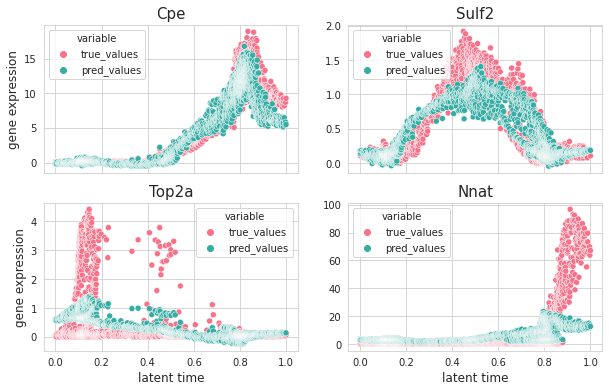

In [27]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(10,6))

sns.scatterplot(data=df_to_plot[sel_genes[0]], x="time", y="value", hue="variable", palette=sns.color_palette("husl", 2), ax=axs[0,0])
axs[0,0].set_title(sel_genes[0], fontsize=15)
axs[0,0].set_ylabel('gene expression', fontsize=12)

sns.scatterplot(data=df_to_plot[sel_genes[1]], x="time", y="value", hue="variable", palette=sns.color_palette("husl", 2), ax=axs[0,1])
axs[0,1].set_title(sel_genes[1], fontsize=15)
axs[0,1].set_ylabel('')

sns.scatterplot(data=df_to_plot[sel_genes[2]], x="time", y="value", hue="variable", palette=sns.color_palette("husl", 2), ax=axs[1,0])
axs[1,0].set_title(sel_genes[2], fontsize=15)
axs[1,0].set_xlabel('latent time', fontsize=12)
axs[1,0].set_ylabel('gene expression', fontsize=12)

sns.scatterplot(data=df_to_plot[sel_genes[3]], x="time", y="value", hue="variable", palette=sns.color_palette("husl", 2), ax=axs[1,1])
axs[1,1].set_title(sel_genes[3], fontsize=15)
axs[1,1].set_xlabel('latent time', fontsize=12)
axs[1,1].set_ylabel('')

plt.savefig("./Plots/pancreas_predictions.png", dpi=150, transparent=True, bbox_inches='tight')